In [2]:
import dgl
from dgl import DGLGraph
import torch
import numpy as np
from exp.model import GAE
from exp.utils import *

from torch.nn.functional import binary_cross_entropy, binary_cross_entropy_with_logits
from fastprogress.fastprogress import master_bar, progress_bar
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = 'cora'
features = load_data(dataset)
features = np.array(features.todense(), dtype=np.float32)
g = DGLGraph(load_graph(dataset))
g.ndata['h'] = features

In [4]:
val_edges, val_edges_false, test_edges, test_edges_false = make_test_val_edges(g)

In [5]:
in_feats = features.shape[1]

In [6]:
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
g.ndata['norm'] = norm.unsqueeze(1)
adj = g.adjacency_matrix().to_dense()
pos_weight = torch.Tensor([float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()])

adj_label = adj.view(-1)
weight_mask = adj_label == 1
weight_tensor = torch.ones(weight_mask.size(0)) 
weight_tensor[weight_mask] = pos_weight

In [7]:
model = GAE(in_feats, [32,16], dropout=0.)

In [8]:
device = torch.device('cuda: 1')
model = model.to(device)
g = g.to(device)
adj = adj.to(device)
weight_tensor = weight_tensor.to(device)

In [ ]:
loss_function=binary_cross_entropy
losses = []
model.train()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
for e in progress_bar(range(20)):
    adj_logits = model(g)
    optim.zero_grad()
    
    loss = loss_function(adj_logits.view(-1), adj.view(-1), weight=weight_tensor)
    loss.backward()
    optim.step()
    val_roc, val_ap = get_scores(val_edges, val_edges_false, adj_logits)
    losses.append(loss.item())
    print((f'Epoch:{e:2d} loss: {loss.item():.5f} | acc: {get_acc(adj_logits, adj):.5f} | '
           f'val_roc: {val_roc} | val_ap: {val_ap}'))

In [ ]:
get_scores(test_edges, test_edges_false, adj_logits)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

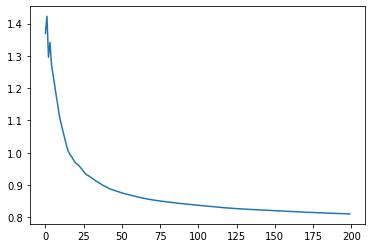

In [10]:
plt.plot(losses)